This file contains functions to visualize and select the best training curves from our experiments.

In [24]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('cmu_paper')

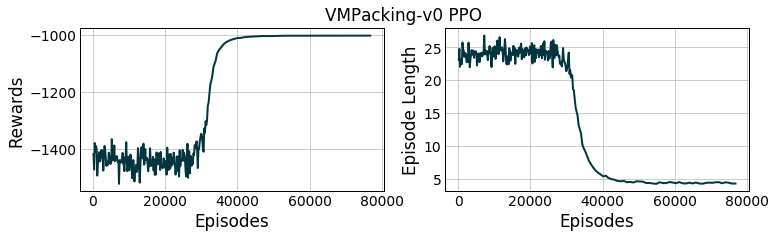

/home/christian/ray_results/PPO/PPO_VMPacking-v0_54af0b06_2020-04-16_10-04-5817i5osca


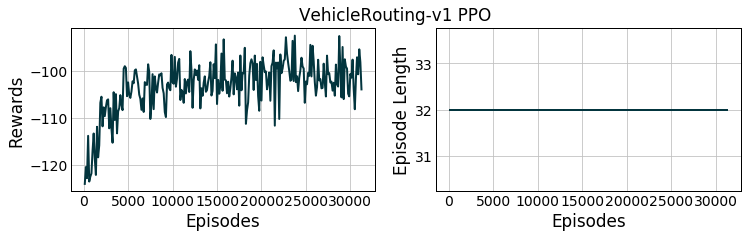

/home/christian/ray_results/PPO/PPO_VehicleRouting-v1_238b7de5_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-02_20-20-4547ljic2_


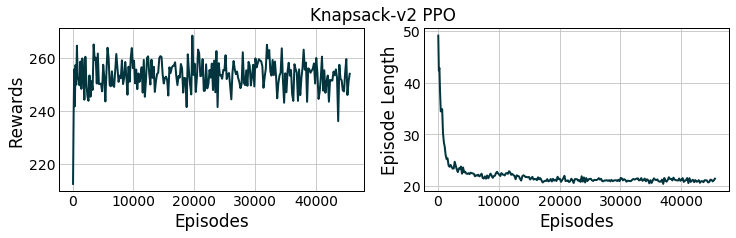

/home/christian/ray_results/PPO/PPO_Knapsack-v2_56320e97_5_entropy_coeff=0.001,lr=1e-06,vf_share_layers=False_2020-04-14_19-27-41ejtyiz3d


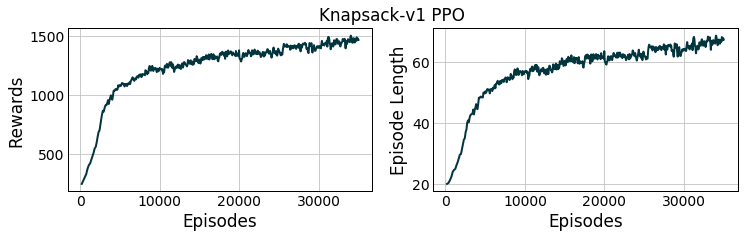

/home/christian/ray_results/PPO/PPO_Knapsack-v1_0a0c1d2d_7_entropy_coeff=0.001,lr=0.0001,vf_share_layers=False_2020-04-01_02-48-14vl_32i4a


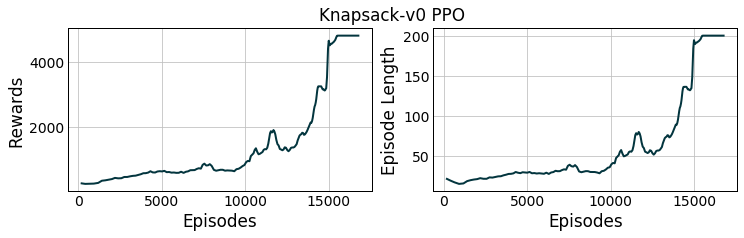

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da3_1_lr=0.001,vf_share_layers=True_2020-03-21_16-39-26_z6_97l8


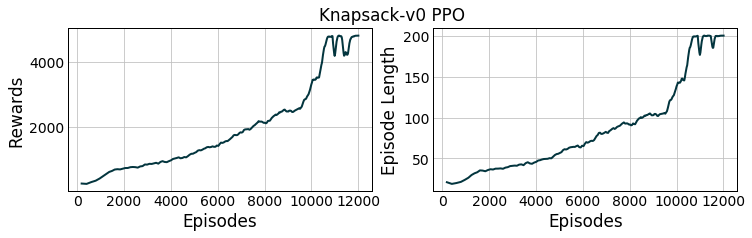

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da4_2_lr=0.0001,vf_share_layers=True_2020-03-21_17-13-03j4saa4bw


In [58]:
# Get data from results folders
result_path = '../or_gym/benchmarks/results'
results = os.listdir(result_path)
envs = set([i.split('_')[0] for i in results])
for env in envs:
    result_data = pd.DataFrame()
    for data_path in results:
        if env in data_path:
            _result_data = pd.read_csv(
                os.path.join(result_path, data_path))
            result_data = pd.concat([result_data, _result_data])
            
    top_results = result_data.loc[
        result_data['episode_reward_mean']==result_data['episode_reward_mean'].max()]
    
    for _path in top_results['logdir']:
        algo_name = os.path.basename(_path).split('_')[0]
        train_data = pd.read_csv(_path + '/progress.csv')
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        ax[0].plot(train_data['episodes_total'], train_data['episode_reward_mean'])
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
#         ax[0].set_title(env + ' ' + algo_name)
        
        ax[1].plot(train_data['episodes_total'], train_data['episode_len_mean'])
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Episode Length')
        plt.suptitle(env + ' ' + algo_name)
#         plt.tight_layout()
        plt.show()
        print(_path)

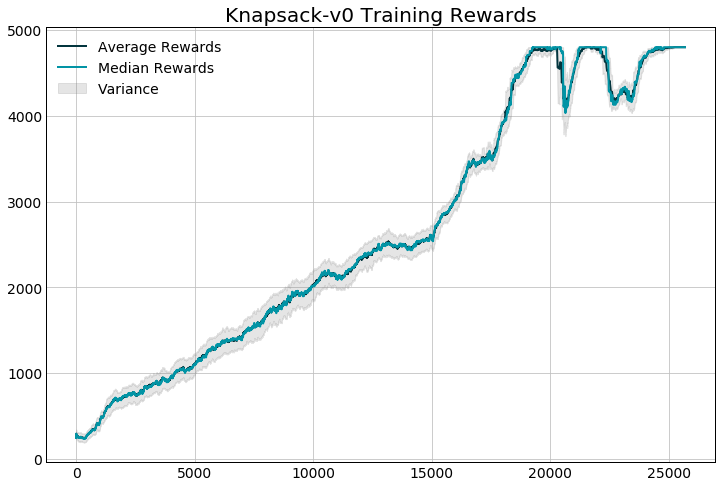

In [48]:
# Get episode totals
ep_stats = ['hist_stats/episode_reward']

for i in ep_stats:
    vals = None
    ep_vals = train_data[i].values
    for j in ep_vals:
        ep_vals = np.array(re.findall(r"[-+]?\d*\.\d+|\d+", j)).astype(float)
        if vals is None:
            vals = ep_vals.copy()
        else:
            vals = np.hstack([vals, ep_vals.copy()])

window = 100
reward_var = np.array([np.std(vals[i-window:i+1]) 
                       if i>window else np.std(vals[:i+1]) 
                       for i, j in enumerate(vals)])
med_reward = np.array([np.median(vals[i-window:i+1]) 
                       if i>window else np.median(vals[:i+1]) 
                       for i, j in enumerate(vals)])
ep_max = np.array([np.max(vals[i-window:i+1]) 
                       if i>window else np.max(vals[:i+1]) 
                       for i, j in enumerate(vals)])
ep_min = np.array([np.min(vals[i-window:i+1]) 
                       if i>window else np.min(vals[:i+1]) 
                       for i, j in enumerate(vals)])
mean_vals = np.array([np.mean(vals[i-window:i+1]) 
                       if i>window else np.mean(vals[:i+1]) 
                       for i, j in enumerate(vals)])

fill_max = np.where(mean_vals + reward_var<=ep_max, mean_vals+reward_var, ep_max)
fill_min = np.where(mean_vals - reward_var>0, mean_vals-reward_var, 0)

plt.figure(figsize=(12,8))
plt.plot(mean_vals, label='Average Rewards')
# plt.plot(med_reward, label='Median Rewards')
plt.fill_between(np.arange(mean_vals.shape[0]), fill_min, fill_max,
                 color='gray', alpha=0.2, label='Variance')
plt.title('Knapsack-v0 Training Rewards')
plt.legend()
plt.show()

In [41]:
data = pd.read_csv('../or_gym/benchmarks/results/VMPacking-v0_or_gym_tune_2020-04-13.csv')
data

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,info/learner/default_policy/entropy_coeff,config/entropy_coeff,config/env,config/env_config,config/lr,config/model,config/num_workers,config/vf_clip_param,config/vf_share_layers,logdir
0,-1003.493313,-1250.342241,-1097.462244,24.558282,163,4000,True,1000000,56812,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
1,-1004.183975,-1228.260401,-1110.124231,27.376712,146,4000,True,1000000,56183,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
2,-1004.846325,-1192.904492,-1070.930941,18.741784,213,4000,True,1000000,78604,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
3,-1002.134130,-1152.306792,-1067.583072,19.588235,204,4000,True,1000000,77533,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
4,-1000.920722,-1555.138960,-1148.324953,14.921933,269,4000,True,1000000,44089,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
5,-1006.995235,-1641.756196,-1179.577573,16.196787,249,4000,True,1000000,42714,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...


In [7]:
import or_gym
import numpy as np

In [4]:
env = or_gym.make('VMPacking-v0')

In [5]:
bin_vars = env.n_pms * env.step_limit**2 + env.n_pms * env.step_limit + env.n_pms * env.step_limit
bin_vars

2102400

In [22]:
30 / 26.7 - 1

0.12359550561797761

In [6]:
def bin_var_calc(steps, pms=100):
    return pms * (steps**2 + 2*steps)

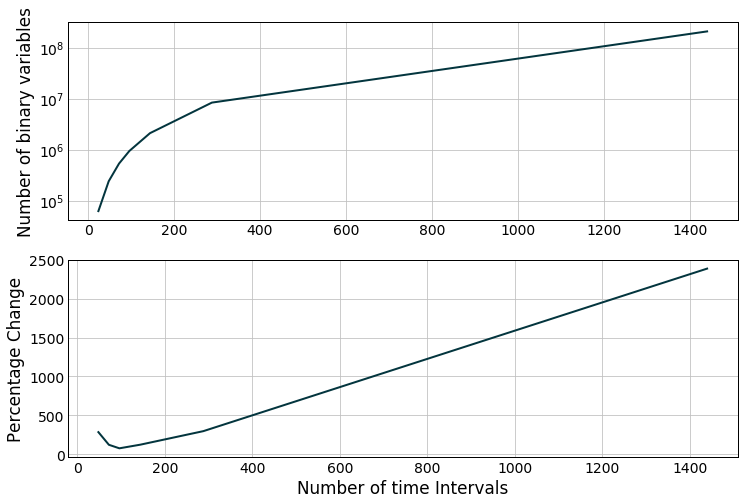

In [28]:
# Intervals
t_intervals = np.array([1, 5, 10, 15, 20, 30, 60])
t_steps = 24 * 60 / t_intervals
bin_vars = np.zeros(t_steps.shape)
for i, t in enumerate(t_steps[::-1]):
    bin_vars[i] = bin_var_calc(t)

delta_bv = [(bin_vars[i] / bin_vars[i-1] - 1)*100
            for i, j in enumerate(bin_vars[:-1], 1)]

fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(t_steps[::-1], bin_vars)
ax[0].set_ylabel('Number of binary variables')
ax[0].semilogy()

ax[1].plot(t_steps[::-1][1:], delta_bv)
ax[1].set_ylabel('Percentage Change')

ax[1].set_xlabel('Number of time Intervals')
plt.show()

$\mathcal{O}\big(ik(2+k)\big)$

In [36]:
t_intervals, t_steps

(array([ 1,  5, 10, 15, 20, 30, 60]),
 array([1440.,  288.,  144.,   96.,   72.,   48.,   24.]))

In [25]:
bin_vars[3] / bin_vars[2] - 1

0.7657657657657657